In [1]:
from ruspy.data.data_reading import data_reading
from ruspy.data.data_processing import data_processing
from ruspy.estimation.estimation import estimate
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
beta = 0.9999
init_dict = {
    "groups": "group_4",
    "beta": beta,
    "maint_func": "linear",
    "binsize": 5000,
    "states": 90,
}

In [3]:
data_reading()
repl_data = data_processing(init_dict)
trans_results, cost_results = estimate(init_dict, repl_data, repl_4=True)
print(trans_results, cost_results)

{'state_count': array([[68, 94,  9, ...,  0,  0,  0],
       [ 0, 44, 59, ...,  0,  0,  0],
       [ 0,  0, 47, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  1,  1,  0],
       [ 0,  0,  0, ...,  0,  1,  1],
       [ 0,  0,  0, ...,  0,  0,  1]]), 'x': array([0.39189189, 0.59529357, 0.01281454]), 'fun': 3140.5705570938244, 'trans_count': array([1682, 2555,   55])}       fun: 163.58583993344618
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.16529009e-04, -3.69482223e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 42
      nit: 12
   status: 0
  success: True
        x: array([10.07759093,  2.29408834])


In [4]:
max_state = trans_results["state_count"].shape[0] # 78
scale = 3 
num_bins = int(max_state / scale) # 26

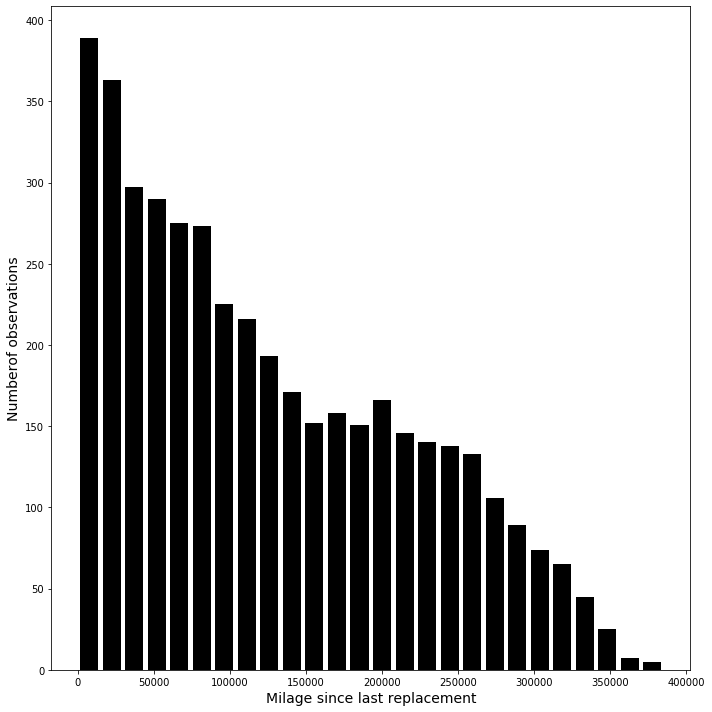

In [5]:
numobs_per_state = trans_results["state_count"].sum(axis=1)
hist_data = np.array([])
for i, val in enumerate(numobs_per_state):
    hist_data = np.append(hist_data, np.full(val, i))
hist_data = hist_data * init_dict["binsize"]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_ylabel(r"Numberof observations", fontsize=14)
ax.set_xlabel(r"Milage since last replacement", fontsize=14)
# ax.set_ylim([0, 1.15 * numobs_per_state[0]])
ax.hist(hist_data, bins=num_bins, color="black", rwidth=0.8)
plt.tight_layout()
plt.show()

In [6]:
state_mat = trans_results["state_count"]
trans_mat = state_mat/state_mat.sum(axis=1)[:,None]

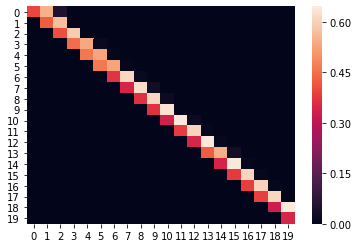

In [8]:
sns.heatmap(trans_mat[0:20, 0:20])